In [1]:
# this cell is for Google Colab execution
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 49.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 11.8 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.9 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=eaadc861df51751e99facd6a9e2a14c1f817f654f48a7470a35778f2d61c

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# prepare data:
# each node is pair of countries, order matters so AB and BA are two different nodes
# edges are based on similarity
# node features are the concatenated features of the country pairs (in the correct order)
# build such a graph for each year separately
feature_data = pd.read_csv('../../data/features/features_interpolated.csv', encoding='latin-1', engine='python')
feature_data.drop(columns=['Unnamed: 0'], inplace=True)
migration_data = pd.read_csv('../../data/labels/OECD_acquisition_data_interpolated.csv', encoding='latin-1', engine='python')
migration_data.drop(columns=['Unnamed: 0'], inplace=True)

features_per_country = feature_data.columns[2:]
years = migration_data['Year'].unique()
countries = migration_data['CO2'].unique()

merged_data = pd.merge(feature_data, migration_data, left_on=["Country", "Year"], right_on=["COU", "Year"])

# Merge the third dataset based on country and year
merged_data = pd.merge(feature_data, merged_data, left_on=["Country", "Year"], right_on=["CO2", "Year"])

merged_data.drop(columns=["COU", "CO2"], inplace=True)

label_column = "y"
merged_data.rename(columns={"Value": "y"}, inplace=True)

# discretize migration flow values based on quantiles
num_classes = 2
merged_data["y"] = pd.qcut(merged_data["y"], q=num_classes, labels=range(num_classes))

In [3]:

cols_to_skip = ["Country_x", "Country_y", "Year", "y"]
cols_to_norm = list(set(merged_data.columns).difference(set(cols_to_skip)))

# normalize data
merged_data[cols_to_norm] = (merged_data[cols_to_norm]-merged_data[cols_to_norm].mean())/merged_data[cols_to_norm].std()
merged_data

,Country_x,Year,Carbon Emissions_x,Education Expenditure_x,Foreign Direct Investment (FDI) Inflows_x,GDP_x,Health Expenditure_x,Inflation Rate_x,Internet Penetration_x,Life Expectancy_x,...,Education Expenditure_y,Foreign Direct Investment (FDI) Inflows_y,GDP_y,Health Expenditure_y,Inflation Rate_y,Internet Penetration_y,Life Expectancy_y,Renewable Energy Production_y,Unemployment Rate_y,y
0,AUS,2000,-0.034998,-0.454657,-0.289280,-0.298431,-0.607745,1.153977,-0.938189,-0.116250,...,0.174311,-0.368066,-0.371296,0.147570,0.054876,-1.501728,-0.518563,0.333188,-0.646840,0
1,AUS,2000,-0.034998,-0.454657,-0.289280,-0.298431,-0.607745,1.153977,-0.938189,-0.116250,...,0.359953,0.620936,-0.358126,-0.419606,0.158750,-1.687690,-0.665665,-1.111867,-0.175451,1
2,AUS,2000,-0.034998,-0.454657,-0.289280,-0.298431,-0.607745,1.153977,-0.938189,-0.116250,...,0.025932,0.369052,-0.188773,-0.302375,0.249756,-0.741608,-0.140708,0.078859,-0.115907,1
3,AUS,2000,-0.034998,-0.454657,-0.289280,-0.298431,-0.607745,1.153977,-0.938189,-0.116250,...,-0.668892,-0.188356,-0.343983,0.105336,-0.354227,-0.923311,0.045915,-0.143680,-1.150481,1
4,AUS,2000,-0.034998,-0.454657,-0.289280,-0.298431,-0.607745,1.153977,-0.938189,-0.116250,...,-1.451215,-0.412945,-0.410982,-0.873520,0.834449,-2.242824,-0.975198,0.617575,0.792136,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14737,USA,2020,4.487322,0.587816,1.362627,6.584184,4.673587,-0.523285,0.959502,-0.935055,...,0.453325,-0.523418,-0.316318,1.189990,-0.495711,1.235498,1.328177,2.410022,-0.713827,1
14738,USA,2020,4.487322,0.587816,1.362627,6.584184,4.673587,-0.523285,0.959502,-0.935055,...,0.525054,-0.421880,-0.366480,0.535975,-0.273049,1.056610,0.981692,0.518734,-0.669169,1
14739,USA,2020,4.487322,0.587816,1.362627,6.584184,4.673587,-0.523285,0.959502,-0.935055,...,-0.183264,-0.236796,-0.237222,-1.128765,0.590546,0.637819,-1.109627,-0.491071,-1.026432,1
14740,USA,2020,4.487322,0.587816,1.362627,6.584184,4.673587,-0.523285,0.959502,-0.935055,...,0.327801,-0.466609,-0.419164,0.265223,-1.193618,0.785622,0.355182,0.010652,-0.577372,0


In [4]:
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
import networkx as nx

graphs=[]
similarity = False
threshold = 0.38 # 0.38 for dissimilairity and 0.79 for similarity
sparsity_values = []

# for each year create the graph
for year in tqdm(years):
    # empty graph
    graph = nx.Graph()

    per_year_df = merged_data[merged_data['Year'] == year].reset_index(drop=True)

    first_country_list = per_year_df['Country_x']
    second_country_list = per_year_df['Country_y']
    per_year_df['countries_pair'] = [country1+"_"+country2 for country1, country2 in zip(first_country_list, second_country_list)]
    per_year_df.drop(['Country_x', 'Country_y'], axis=1, inplace=True)
    distances = euclidean_distances(per_year_df[cols_to_norm])
    distances = distances / distances.max()  # normalize
    #  Calculate similarity between pairs of pairs of countries
    similarities = 1 - distances
    np.fill_diagonal(similarities, np.nan)
    #  Convert to matrix
    similarities_df = pd.DataFrame(similarities, index=per_year_df['countries_pair'].values, columns=per_year_df['countries_pair'].values)

    if similarity:
        filtered_matrix = similarities_df[similarities_df >= threshold]
    else:
        filtered_matrix = similarities_df[similarities_df <= threshold]

    edge_list = np.argwhere(~np.isnan(filtered_matrix.to_numpy()))  # get indices of non nan values

    node_index = {}
    for i, row in per_year_df.iterrows():
        node_index[i] = row["countries_pair"]
        graph.add_node(row['countries_pair'], x=row[cols_to_norm], y=row[label_column])
    for edge in edge_list:
        graph.add_edge(node_index[edge[0]], node_index[edge[1]])
    graph.remove_edges_from(list(nx.selfloop_edges(graph)))
    num_edges = graph.number_of_edges()
    max_edges = graph.number_of_nodes() * (graph.number_of_nodes() - 1)
    sparsity = num_edges / max_edges
    sparsity_values.append(sparsity)
    graphs.append(graph)

print("Mean sparsity: ", np.mean(sparsity_values))

100%|██████████| 21/21 [00:09<00:00,  2.13it/s]

Mean sparsity:  0.05247276455074838


In [5]:
from torch_geometric.utils.convert import from_networkx

# convert to Data object and reshape y values to meet GNN requirements
data_graphs = [from_networkx(graphs[i]) for i in tqdm(range(len(graphs)))]
# for i in range(len(data_graphs)):  # this is only needed for regression
    # data_graphs[i].y = data_graphs[i].y.reshape(-1, 1)
data_graphs[0]

100%|██████████| 21/21 [00:05<00:00,  4.11it/s]


Data(x=[702, 20], edge_index=[2, 54986], y=[702])

In [6]:
train_data = data_graphs[:17]
test_data = data_graphs[17:]

In [7]:
import time
import torch
import pickle
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import TAGConv, GATv2Conv
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.loader import DataLoader as pyg_DataLoader



class GNN_Example(nn.Module):
  """
    This class defines a PyTorch module that takes in a graph represented in the PyTorch Geometric Data format,
    and outputs a tensor of predictions for each node in the graph. The model consists of one or more TAGConv layers,
    which are a type of graph convolutional layer.

    Args:
        node_dim (int): The number of node inputs.
        output_dim (int, optional): The number of outputs (default: 1).
        hidden_dim (int, optional): The number of hidden units in each GNN layer (default: 50).
        n_gnn_layers (int, optional): The number of GNN layers in the model (default: 1).
        K (int, optional): The number of hops in the neighbourhood for each GNN layer (default: 2).
        dropout_rate (float, optional): The dropout rate to be applied to the output of each GNN layer (default: 0).

    """
  def __init__(self, node_dim, output_dim=1, hidden_dim=50, n_gnn_layers=1, K=2, dropout_rate=0):
    super().__init__()
    self.node_dim = node_dim
    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.n_gnn_layers = n_gnn_layers
    self.K = K
    self.dropout_rate = dropout_rate

    self.convs = nn.ModuleList()

    if n_gnn_layers == 1:
      self.convs.append(TAGConv(node_dim, output_dim, K=K))
    else:
      self.convs.append(TAGConv(node_dim, hidden_dim, K=K))

      for l in range(n_gnn_layers-2):
          self.convs.append(TAGConv(hidden_dim, hidden_dim, K=K))

      self.convs.append(TAGConv(hidden_dim, output_dim, K=K))

  def forward(self, data):
      """Applies the GNN to the input graph.

        Args:
            data (Data): A PyTorch Geometric Data object representing the input graph.

        Returns:
            torch.Tensor: The output tensor of the GNN.

        """
      x = data.x
      edge_index = data.edge_index

      for i in range(len(self.convs)-1):
          x = self.convs[i](x=x, edge_index=edge_index)
          x = nn.Dropout(self.dropout_rate, inplace=False)(x)
          x = nn.PReLU()(x)

      x = self.convs[-1](x=x, edge_index=edge_index)
      # x = nn.Sigmoid()(x)

      return x

In [8]:
# Set model parameters
node_dim = train_data[0].x.shape[1]
output_dim = num_classes
hidden_dim = 64
n_gnn_layers = 3
K = 2
dropout_rate = 0

# Create model
model = GNN_Example(node_dim, output_dim, hidden_dim, n_gnn_layers, K, dropout_rate)
print(model)

GNN_Example(
  (convs): ModuleList(
    (0): TAGConv(20, 64, K=2)
    (1): TAGConv(64, 64, K=2)
    (2): TAGConv(64, 2, K=2)
  )
)


In [9]:
#################################################################
def train_epoch(model, loader, optimizer, criterion, device='cpu'):
    """
    Trains a neural network model for one epoch using the specified data loader and optimizer.

    Args:
        model (nn.Module): The neural network model to be trained.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the training data.
        optimizer (torch.optim.Optimizer): The PyTorch optimizer used for training the model.
        device (str): The device used for training the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_instances = 0
    for batch in loader:
        optimizer.zero_grad()  # Clear gradients.
        out = model(batch)  # Perform a single forward pass.
        loss = criterion(out, batch.y) # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        # compute accuracy
        pred = out.argmax(dim=1)
        total_loss += loss
        correct_predictions = np.sum((pred==batch.y).detach().cpu().numpy())
        total_correct += correct_predictions
        total_instances += len(batch.y)

    accuracy = round(total_correct/total_instances, 4)
    return total_loss / len(loader), accuracy

# test function of the graphsage model
def evaluate_epoch(model, loader, criterion, device='cpu'):
    """
    Evaluates the performance of a trained neural network model on a dataset using the specified data loader.

    Args:
        model (nn.Module): The trained neural network model to be evaluated.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the evaluation data.
        device (str): The device used for evaluating the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """
    model.eval()
    total_loss = 0
    total_correct = 0
    total_instances = 0
    for batch in loader:
        out = model(batch)
        loss = criterion(out, batch.y)
        total_loss += loss

        # compute accuracy
        pred = out.argmax(dim=1)
        total_loss += loss
        correct_predictions = np.sum((pred==batch.y).detach().cpu().numpy())
        total_correct += correct_predictions
        total_instances += len(batch.y)
    accuracy = round(total_correct/total_instances, 4)
    return total_loss / len(loader), accuracy
#################################################################

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
# Set training parameters
learning_rate = 0.1
batch_size = 2
num_epochs = 500

# Create the optimizer to train the neural network via back-propagation
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4)

# Create the training and validation dataloaders to "feed" data to the GNN in batches
train_loader = pyg_DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = pyg_DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [12]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device=device)
    test_loss, test_acc = evaluate_epoch(model, test_loader, criterion, device=device)
    if epoch % 10 == 0:
        print("Epoch ", epoch, ", train loss ", train_loss.detach().cpu().numpy(), ", train acc ", train_acc, ", test acc ", test_acc)

    train_losses.append(train_loss.detach().cpu().numpy())
    test_accs.append(test_acc)
    test_losses.append(test_loss.detach().cpu().numpy())
    train_accs.append(train_acc)

Epoch  10 , train loss  0.48463112 , train acc  0.7709 , test acc  0.791
Epoch  20 , train loss  0.449717 , train acc  0.7872 , test acc  0.7959
Epoch  30 , train loss  0.42616394 , train acc  0.7995 , test acc  0.8038
Epoch  40 , train loss  0.40474018 , train acc  0.8121 , test acc  0.7924
Epoch  50 , train loss  0.3884541 , train acc  0.8192 , test acc  0.8095
Epoch  60 , train loss  0.37464294 , train acc  0.8307 , test acc  0.7984
Epoch  70 , train loss  0.36839667 , train acc  0.8317 , test acc  0.8212
Epoch  80 , train loss  0.35381547 , train acc  0.8422 , test acc  0.828
Epoch  90 , train loss  0.3696012 , train acc  0.8291 , test acc  0.8191
Epoch  100 , train loss  0.33746138 , train acc  0.8546 , test acc  0.776
Epoch  110 , train loss  0.33275202 , train acc  0.8559 , test acc  0.8091
Epoch  120 , train loss  0.31891465 , train acc  0.8643 , test acc  0.8123
Epoch  130 , train loss  0.31616327 , train acc  0.8643 , test acc  0.791
Epoch  140 , train loss  0.3150264 , train

In [ ]:
# plot the training and validation loss curves
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

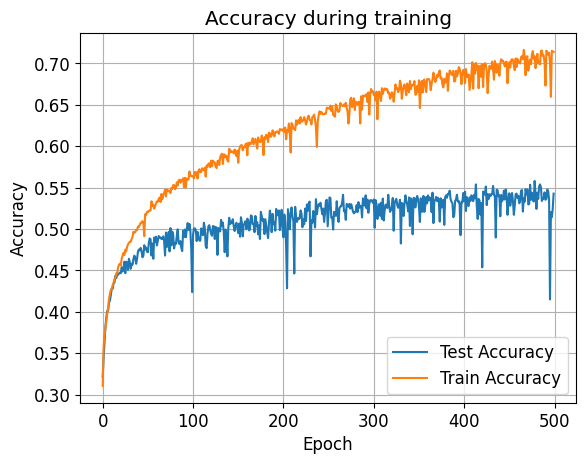

In [20]:
#########################################################################
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_accs, label='Test Accuracy')
ax.plot(train_accs, label='Train Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
#########################################################################

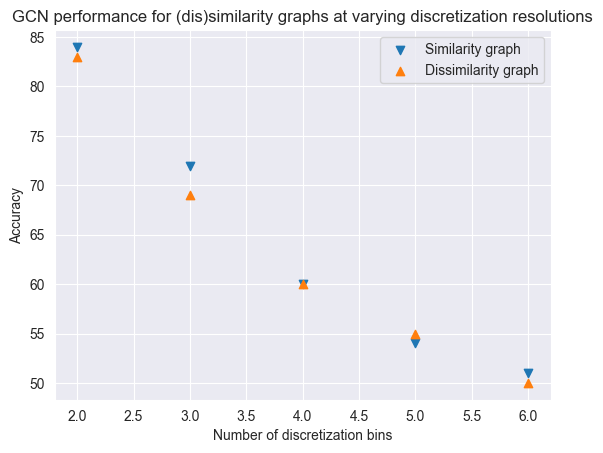

In [22]:
# Results obtained by running the above code with different number of discretized classes.
# All other parameters were fixed for the two types of graph construction.
# thresholds: 0.38 for dissimilarity and 0.79 for similarity
similarity_graph_acc_per_num_class = {2: 84, 3: 72, 4: 60, 5: 54, 6: 51}
dissimilarity_graph_acc_per_num_class = {2: 83, 3: 69, 4: 60, 5: 55 , 6: 50 }
plt.scatter(similarity_graph_acc_per_num_class.keys(), similarity_graph_acc_per_num_class.values(), label="Similarity graph", marker="v")
plt.scatter(dissimilarity_graph_acc_per_num_class.keys(), dissimilarity_graph_acc_per_num_class.values(), label="Dissimilarity graph", marker="^")
plt.ylabel("Accuracy")
plt.xlabel("Number of discretization bins")
plt.title("GCN performance for (dis)similarity graphs at varying discretization resolutions")
plt.legend()
plt.savefig("gcn_acc_num_classes.png")
plt.show()

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer


explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
)

# explanations for each node
#add your code here to visualize the feature importance
explanations = []
for node_index in ind:
  explanation = explainer(data.x, data.edge_index, index=node_index)
  path = 'feature_importance_node_{}.png'.format(node_index)
  explanation.visualize_feature_importance(path, top_k=50)
  print(f"Feature importance plot has been saved to '{path}'")
  explanations.append(explanation)

##################################################################################